(Comentario: En las reglas del curso se solicita explicitar el uso de LLMs declarando inicio y fin en el código, y si hubo que modificar el output. Aquí explicitamos el uso de tales herramientas indicando en cuáles celdas se utilizó y de qué forma. Optamos por utilizar IA generativa para las funciones de visualización de ciertos experimentos.)

# Árboles de Galton-Watson miopes
Consideramos (exploraciones de) **árboles de Galton-Watson** simulados del siguiente modo:
- En la generación $1$ comenzamos con un único nodo inicial $0$.
- En la generación $2$, el nodo $0$ tiene dos hijos, que etiquetamos $1$ y $2$, con probabilidad $p\in [0,1]$, y no tiene ninguno con probabilidad $1-p$.
- Si la generación anterior es no vacía, volvemos a simular en cada uno de los nodos, generando dos nuevos hijos con probabilidad $p$ y ninguno con probabilidad $1-p$.
- Repetimos el proceso hasta que ningún nodo en la generación actual tiene hijos, en tal caso diremos que el árbol se extingue.

Como la cantidad de hijos por nodo es siempre la misma en el evento en que existen, diremos que es un árbol de Galton-Watson *uniforme*.

Este proceso es un *branching process*, o proceso de ramificación, los cuales están bien estudiados en la literatura. Por ejemplo, el proceso muere en tiempo finito c.s. si $p<1/2$ (caso subcrítico) y también si $p=1/2$ (caso crítico). En cambio si $p>1/2$ el proceso puede seguir indefinidamente con probabilidad positiva (caso supercrítico). Esto se sigue del hecho de que cada nodo tiene en media $\mu:= \mathbb E[\# \text{ hijos por nodo}]=2p$ hijos.

Como existe la posibilidad de que las generaciones se reproduzcan de forma indefinida, las funciones de simulación considerarán un tiempo final, y es por esto que en rigor el código genera muestras de *exploraciones* de árboles Galton-Watson.

Consideramos también una variante que llamaremos **árbol de Galton-Watson miope**, siguiendo el trabajo de [Arista-Remenik-Sepúlveda, 2025](https://arxiv.org/abs/2506.05246): este consiste en el mismo proceso, pero condicionado en cada generación a que durante un intervalo de tiempo discreto de largo $T\geq 1$ el proceso no se extinguirá. (Es posible condicionar también a que no ocurran otros eventos medibles, además de la extinción.) El algoritmo para simular estos árboles es el siguiente:
- Simulamos un árbol de Galton-Watson uniforme como en lo anterior.
- Si en una generación el árbol se extingue, retrocedemos $T$ pasos (o volvemos al inicio si estamos en una generación $t<T$) y continuamos la simulación normalmente.

Observamos que en este caso el proceso sigue indefinidamente irrespectivamente del parámetro $p$. Interesará estudiar el efecto de este tipo de *condicionamiento miope* sobre los casos crítico y subcríticos.

A continuación implementamos dos métodos `simular_GW(p,Tf)` y `simular_GW_miope(p,T,Tf)` que realizan los algoritmos aquí descritos, regresando tuplas $(V,E)$ de vértices y aristas.

## Funciones básicas de simulación y visualización:

In [ ]:
import numpy as np

def simular_GW(p, Tf):
    """
    Explora un árbol de Galton-Watson hasta la generación `Tf`.
    Cada nodo `n` tiene 2 hijos (2n+1, 2n+2) con probabilidad p,
    y 0 hijos con probabilidad 1-p.

    Regresa una tupla (V, E) donde:
    - V es una lista de vértices existentes.
    - E es una lista de tuplas (m, n) representando las aristas del árbol.
    """
    V = [0]
    E = []
    nodos_gen_actual = [0]

    for t in range(Tf):
        nodos_gen_siguiente = []

        # Iteramos sobre los padres de la generación actual
        for padre in nodos_gen_actual:
            # Se decide si el padre se reproduce
            if np.random.random() < p:
                # Si se reproduce, sus hijos tienen etiquetas fijas
                hijo1 = 2 * padre + 1
                hijo2 = 2 * padre + 2

                # Se añaden los nuevos nodos y aristas
                V.extend([hijo1, hijo2])
                E.extend([(padre, hijo1), (padre, hijo2)])
                nodos_gen_siguiente.extend([hijo1, hijo2])

        if not nodos_gen_siguiente:
            # Extinción
            break

        nodos_gen_actual = nodos_gen_siguiente

    return (V, E)

def simular_GW_miope(p, T, Tf):
    """
    Simula un árbol de Galton-Watson uniforme y miope. La enumeración de hijos
    es la misma que en simular_GW().

    En caso de extinción, registra el árbol, retrocede T pasos y
    continúa la simulación.

    Regresa:
    - Una lista de tuplas (V, E) para cada árbol extinto y el final, este
    último correspondiente a la última tupla.
    """
    arboles_salida = []

    V = [0]
    E = []
    nodos_gen_actual = [0]
    t = 0

    historial = [(V.copy(), E.copy(), nodos_gen_actual.copy())]

    while t < Tf:
        nodos_gen_siguiente = []

        V_nuevos_en_paso = []
        E_nuevas_en_paso = []

        for padre in nodos_gen_actual:
            if np.random.random() < p:
                hijo1 = 2 * padre + 1
                hijo2 = 2 * padre + 2

                V_nuevos_en_paso.extend([hijo1, hijo2])
                E_nuevas_en_paso.extend([(padre, hijo1), (padre, hijo2)])
                nodos_gen_siguiente.extend([hijo1, hijo2])

        if not nodos_gen_siguiente:
            # Extinción
            arboles_salida.append((V.copy(), E.copy()))

            t_retroceso = max(0, t - T)

            # Restaurar estado desde el historial
            estado_restaurado = historial[t_retroceso]
            V, E, nodos_gen_actual = (
                estado_restaurado[0].copy(),
                estado_restaurado[1].copy(),
                estado_restaurado[2].copy()
            )

            historial = historial[:t_retroceso + 1]
            t = t_retroceso
            continue

        # No hay extinción, se confirma la adición de nodos y aristas
        V.extend(V_nuevos_en_paso)
        E.extend(E_nuevas_en_paso)
        nodos_gen_actual = nodos_gen_siguiente
        t += 1

        historial.append((V.copy(), E.copy(), nodos_gen_actual.copy()))

    arboles_salida.append((V, E))
    return arboles_salida


## Usando `networkx` para visualizar los grafos

In [ ]:
# funciones auxiliares para pasar grafos generados por simular_GW() y
# simular_GW_miope() al objeto Graph de networkx, y para visualizar los árboles
# obtenidos con un formato específico, ambas generadas por Gemini 2.5 Pro.

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math

def tupla_a_nx(arbol_tupla):
    """
    Convierte un árbol del formato (V, E) a un grafo de networkx.

    Añade el atributo 'gen' (generación/profundidad) a cada nodo, que es
    necesario para la función de layout.
    """
    V, E = arbol_tupla
    G = nx.Graph()

    for nodo in V:
        # La generación de un nodo n se calcula con log2(n+1)
        # Se maneja el caso n=0 por separado para evitar log2(0)
        generacion = math.floor(math.log2(nodo + 1)) if nodo >= 0 else -1
        G.add_node(nodo, gen=generacion)

    G.add_edges_from(E)
    return G

def tree_layout(G, root, width=1.0, vert_gap=0.2, vert_loc=0, xcenter=0.5):
    """
    Función de layout adaptada para mostrar un grafo como un árbol.
    """
    pos = {}

    def _layout(node, parent, x, y):
        pos[node] = (x, y)
        # Obtenemos los hijos (vecinos que no son el padre)
        children = [n for n in G.neighbors(node) if n != parent]

        # Ordenamos los hijos para que 2n+1 (izquierda) venga antes que 2n+2 (derecha)
        children.sort()

        if children:
            # El espaciado horizontal depende de la profundidad del nodo padre
            dx = width / (2 ** (G.nodes[node]['gen'] + 1))

            # Como nuestro proceso siempre genera 0 o 2 hijos, solo necesitamos
            # la lógica para un número par de hijos.
            if len(children) % 2 == 0:
                for i, child in enumerate(children):
                    sign = -1 if i < len(children) / 2 else 1
                    pos_idx = i if i < len(children) / 2 else i - len(children) / 2
                    new_x = x + sign * dx * (pos_idx + 0.5)
                    _layout(child, node, new_x, y - vert_gap)
            else:
                # Esta parte está en una versión anterior del código y no se
                # usará con nuestros árboles, pero se mantiene como fallback
                _layout(children[0], node, x, y - vert_gap)
                for i, child in enumerate(children[1:]):
                    sign = -1 if i % 2 == 0 else 1
                    pos_idx = (i // 2) + 1
                    new_x = x + sign * dx * pos_idx
                    _layout(child, node, new_x, y - vert_gap)

    _layout(root, None, xcenter, vert_loc)
    return pos

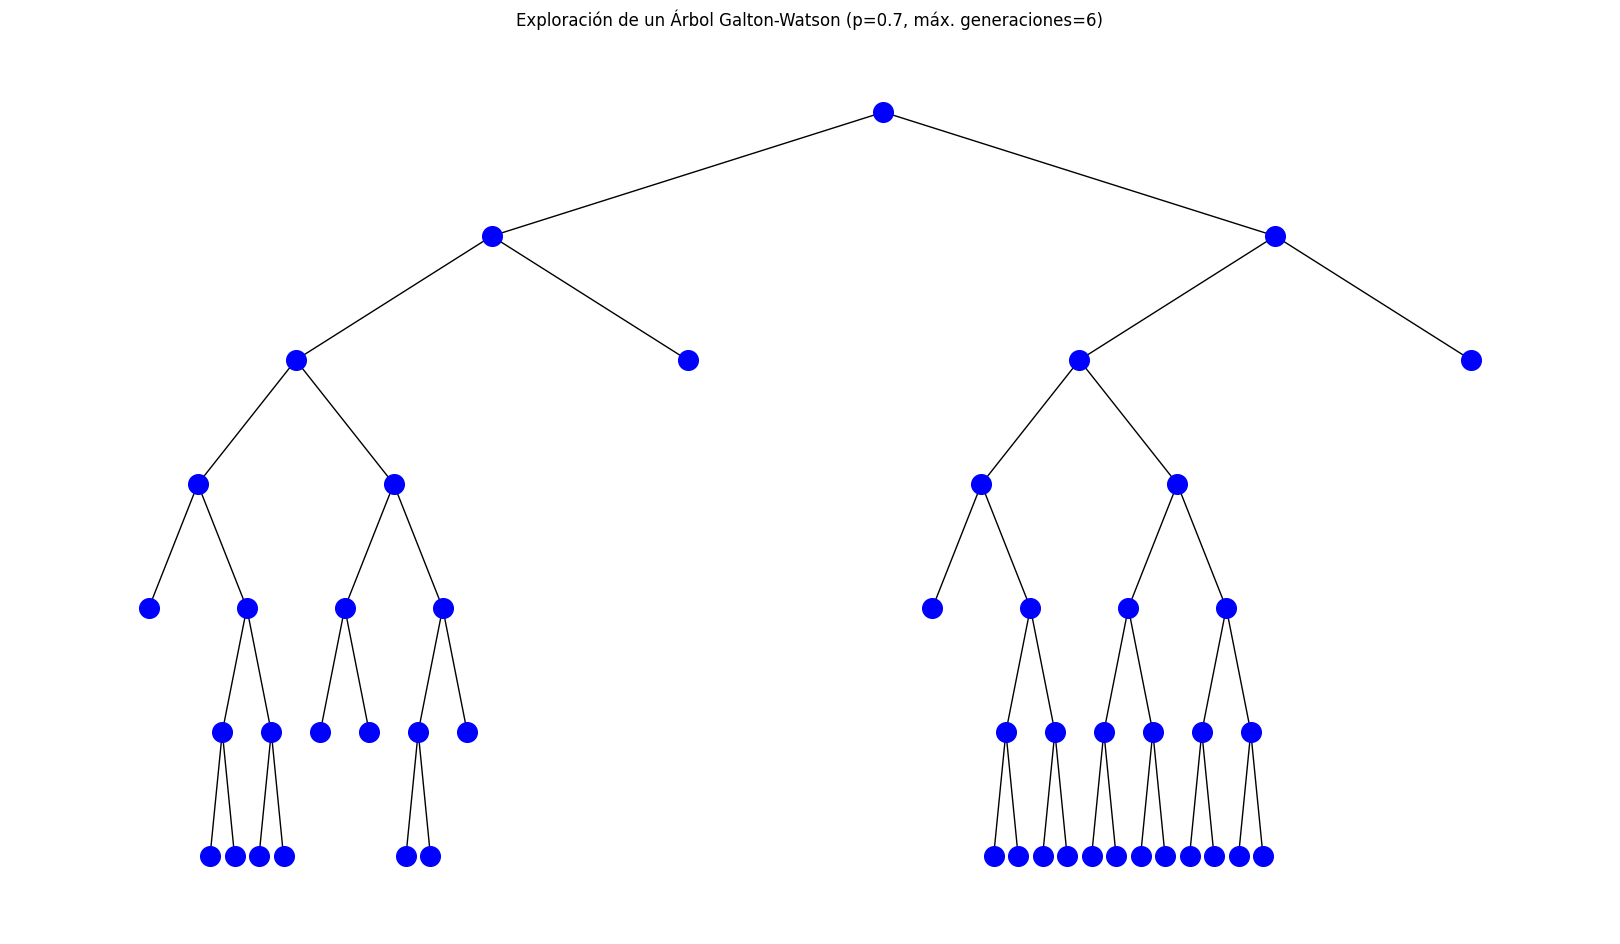

In [ ]:
# usando lo anterior para renderizar un árbol de Galton-Watson

# Parámetros de la simulación
p = 0.7
Tf = 6
np.random.seed(123)

# 1. Simular el árbol para obtener la tupla (V, E)
arbol_tupla = simular_GW(p, Tf)

# 2. Convertir la tupla a un grafo de networkx
arbol_GW_nx = tupla_a_nx(arbol_tupla)

# 3. Calcular el layout del grafo
# El nodo raíz de nuestros árboles siempre es 0
pos = tree_layout(arbol_GW_nx, 0, vert_gap=0.1)

# 4. Visualizar el resultado
plt.figure(figsize=(16, 9))
# Se ajustó node_size y se añadió with_labels para que el grafo sea visible
nx.draw(arbol_GW_nx, pos, with_labels=False, node_size=200, node_color='blue', font_size=8)
plt.title(f"Exploración de un Árbol Galton-Watson (p={p}, máx. generaciones={Tf})")
plt.show()

## Generando una animación

In [ ]:
# rutina que crea un video de la construcción de un árbol de Galton-Watson miope
# generado por Gemini 2.5 Pro tras varios prompts (y haber reestructurado las
# funciones de simulación para etiquetar consistentemente los nodos)

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import base64
from IPython.display import HTML
import math

# --- FUNCIONES AUXILIARES PREVIAMENTE DESARROLLADAS ---

def tupla_a_nx(arbol_tupla):
    V, E = arbol_tupla
    G = nx.Graph()
    for nodo in V:
        generacion = math.floor(math.log2(nodo + 1)) if nodo >= 0 else -1
        G.add_node(nodo, gen=generacion)
    G.add_edges_from(E)
    return G

def tree_layout(G, root, width=1.0, vert_gap=0.2, vert_loc=0, xcenter=0.5):
    pos = {}
    if not G or root not in G: return pos

    def _layout(node, parent, x, y):
        pos[node] = (x, y)
        children = sorted([n for n in G.neighbors(node) if n != parent])
        if children:
            dx = width / (2 ** (G.nodes[node]['gen'] + 1))
            if len(children) % 2 == 0:
                for i, child in enumerate(children):
                    sign = -1 if i < len(children) / 2 else 1
                    pos_idx = i if i < len(children) / 2 else i - len(children) / 2
                    new_x = x + sign * dx * (pos_idx + 0.5)
                    _layout(child, node, new_x, y - vert_gap)
            else: # Fallback
                _layout(children[0], node, x, y - vert_gap)
                for i, child in enumerate(children[1:]):
                    sign = -1 if i % 2 == 0 else 1
                    new_x = x + (sign * dx * ((i // 2) + 1))
                    _layout(child, node, new_x, y - vert_gap)

    _layout(root, None, xcenter, vert_loc)
    return pos

def simular_GW_miope_paso_a_paso(p, T, Tf):
    pasos = []
    color_idx = 0
    V, E = [0], []
    nodos_gen_actual = [0]
    t = 0
    historial = [(V.copy(), E.copy(), nodos_gen_actual.copy())]
    pasos.append({'V': V.copy(), 'E': E.copy(), 't': t, 'extinto': False, 'color_idx': color_idx})
    while t < Tf:
        nodos_gen_siguiente, V_nuevos, E_nuevos = [], [], []
        for padre in nodos_gen_actual:
            if np.random.random() < p:
                hijo1, hijo2 = 2 * padre + 1, 2 * padre + 2
                V_nuevos.extend([hijo1, hijo2])
                E_nuevos.extend([(padre, hijo1), (padre, hijo2)])
                nodos_gen_siguiente.extend([hijo1, hijo2])
        is_extinct = not nodos_gen_siguiente
        if not is_extinct:
            V.extend(V_nuevos)
            E.extend(E_nuevos)
            nodos_gen_actual = nodos_gen_siguiente
            t += 1
            historial.append((V.copy(), E.copy(), nodos_gen_actual.copy()))
            pasos.append({'V': V.copy(), 'E': E.copy(), 't': t, 'extinto': False, 'color_idx': color_idx})
        else:
            pasos.append({'V': V.copy(), 'E': E.copy(), 't': t, 'extinto': True, 'color_idx': color_idx})
            color_idx += 1
            t_retroceso = max(0, t - T)
            V, E, nodos_gen_actual = historial[t_retroceso]
            V, E, nodos_gen_actual = V.copy(), E.copy(), nodos_gen_actual.copy()
            historial = historial[:t_retroceso + 1]
            t = t_retroceso
            pasos.append({'V': V.copy(), 'E': E.copy(), 't': t, 'extinto': False, 'color_idx': color_idx})
    return pasos

# --- FUNCIÓN DE ANIMACIÓN REFACTORIZADA Y CORREGIDA ---

def animate_GW_miope_refactored(p, T, Tf, pause_on_death_secs=1.5, fps=5):
    print("Paso 1/4: Simulando y capturando todos los estados...")
    pasos = simular_GW_miope_paso_a_paso(p, T, Tf)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

    # --- PASO 2: CORRECCIÓN APLICADA AQUÍ ---
    print("Paso 2/4: Calculando layout estable a partir de la unión de todos los nodos...")

    # Recolectar la UNIÓN de todos los vértices y aristas que han existido
    all_V = set()
    all_E = set()
    for paso in pasos:
        all_V.update(paso['V'])
        all_E.update(frozenset(e) for e in paso['E']) # Usar frozenset para que las aristas sean hashables

    # Construir el grafo maestro a partir de la unión de todos los elementos
    V_master = list(all_V)
    E_master = [tuple(e) for e in all_E]
    G_master = tupla_a_nx((V_master, E_master))
    master_pos = tree_layout(G_master, 0, vert_gap=0.1)

    if not master_pos and 0 in G_master:
        master_pos[0] = (0.5, 0)

    # --- El resto de la función continúa desde aquí ---
    print("Paso 3/4: Preparando frames para la animación...")
    frames_data = []
    for paso in pasos:
        G_frame = tupla_a_nx((paso['V'], paso['E']))
        color = colors[paso['color_idx'] % len(colors)]
        if paso['extinto']:
            title = f"Árbol Galton-Watson (p={p}, T={T}) | Generación: {paso['t']+1}/{Tf} -> ¡EXTINCIÓN! Retrocediendo..."
            for _ in range(int(fps * pause_on_death_secs)):
                frames_data.append((G_frame, color, title))
        else:
            title = f"Árbol Galton-Watson (p={p}, T={T}) | Generación: {paso['t']+1}/{Tf}"
            frames_data.append((G_frame, color, title))

    final_frame = frames_data[-1]
    final_title = f"Árbol Galton-Watson Final (p={p}, T={T}, Tf={Tf})"
    frames_data.append((final_frame[0], final_frame[1], final_title))
    print(f"Simulación completa. {len(frames_data)} frames preparados.")

    fig, ax = plt.subplots(figsize=(16, 9))

    def update(frame_data):
        G_frame, color, title = frame_data
        ax.clear()
        nx.draw_networkx_nodes(G_master, master_pos, node_size=10, node_color='#cccccc', ax=ax)
        nx.draw_networkx_nodes(G_frame, master_pos, nodelist=list(G_frame.nodes()), node_size=20, node_color='gray', ax=ax)
        nx.draw_networkx_edges(G_frame, master_pos, edge_color=color, ax=ax)
        ax.set_title(title, fontsize=16)
        ax.set_xticks([])
        ax.set_yticks([])

    print("Paso 4/4: Creando y guardando el video (esto puede tardar)...")
    ani = FuncAnimation(fig, update, frames=frames_data, interval=1000/fps)
    video_filename = 'galton_watson_miope_refactored.mp4'
    ani.save(video_filename, writer='ffmpeg', fps=fps, dpi=120)
    plt.close(fig)
    print("Video guardado con éxito.")
    return video_filename

# --- Parámetros de Simulación ---
p = 0.5
T = 3
Tf = 12
np.random.seed(123)

# --- Generar y mostrar la animación ---
video_file = animate_GW_miope_refactored(p, T, Tf)

try:
    with open(video_file, "rb") as video:
        video_encoded = base64.b64encode(video.read()).decode('ascii')
    display(HTML(f"""
    <video width="80%" controls autoplay loop>
        <source src="data:video/mp4;base64,{video_encoded}" type="video/mp4">
    Your browser does not support the video tag.
    </video>
    """))
except FileNotFoundError:
    print(f"No se pudo encontrar el archivo de video: {video_file}")

Paso 1/4: Simulando y capturando todos los estados...
Paso 2/4: Calculando layout estable a partir de la unión de todos los nodos...
Paso 3/4: Preparando frames para la animación...
Simulación completa. 55 frames preparados.
Paso 4/4: Creando y guardando el video (esto puede tardar)...
Video guardado con éxito.


# Árboles multi-Galton-Watson

Consideramos ahora procesos de *branching* donde los nodos pueden ser de distinto tipo: en este trabajo consideraremos solo dos tipos, nodos azules y rojos. Esto permite asignar distintas probabilidades de transición a distintos eventos: por ejemplo, partiremos considerando que en cada generación,
- Los nodos azules tienen una probabilidad $1/4$ de tener hijos.
  - Si ocurre esto, tienen 4 hijos azules con probabilidad $1/4$, y
  - Tienen 2 hijos rojos con probabilidad $3/4$.
- Los nodos rojos tienen una probabilidad $1/3$ de tener hijos.
  - Si ocurre esto, tienen 1 hijo azul con probabilidad $1/3$, y
  - Tienen 2 hijos rojos con probabilidad $2/3$.

Viendo la cantidad de hijos en la $n$-sima generación como un vector, por ejemplo $(\text{Azul}_n, \text{Rojo}_n)$ en este caso, es fácil comprobar que el proceso es una cadena de Markov. En el código simulamos esta cadena de Markov en lugar de construir explícitamente el gráfico para mayor eficiencia computacional, problema ya evidente en el caso uniforme y con un tipo de nodo.

In [ ]:
import numpy as np

def multiGW(estado_actual, prob_hijos, eventos_transicion):
    '''
    Simula un paso de un proceso Galton-Watson múltiple.

    Dado un n-vector 'estado_actual' con la cantidad de nodos de cada color (n),
    un n-vector 'prob_hijos' con las probabilidades respectivas de que cada
    color tenga hijos, y un arreglo multi-dimensional 'eventos_transicion' que
    contiene los posibles eventos de hijos y sus respectivas probabilidades para
    cada color, simula un paso del proceso y devuelve el nuevo estado.

    Ejemplo de uso: para las probabilidades de transición del caso sub-crítico
    descrito en el Colab y condición inicial (1,1), i.e. un nodo de cada color,
    se tiene lo siguiente:
        multiGW(
            [1,1],
            [1/4, 1/3],
            [ [[1/4, [4,0]], [3/4, [0,2]]] , [[1/3, [1,0]], [2/3, [0,2]]] ]
        )

    Así,
      - eventos_transicion[i] contiene todos los eventos asociados al color i.
      - eventos_transicion[i][j][0] es la probabilidad de que ocurra el j-ésimo
        evento asociado al color i.
      - eventos_transicion[i][j][1] es el 'delta' que aporta este evento al
        siguiente estado de la cadena.
    '''

    # Convertimos a array de numpy
    estado_actual = np.array(estado_actual)
    n_colores = len(estado_actual)

    # Inicializar el output en ceros
    nuevo_estado = np.zeros(n_colores, dtype=int)

    # Iteramos por cada color (tipo de nodo) existente
    for i in range(n_colores):
        n_individuos = estado_actual[i]

        # Si no hay individuos de este color, pasamos al siguiente
        if n_individuos == 0:
            continue

        # --- PASO 1: ¿Quiénes se reproducen? ---
        # Usamos una Binomial(n, p) donde:
        # n = cantidad actual de individuos de color i
        # p = probabilidad de tener hijos (prob_hijos[i])
        p_reproducir = prob_hijos[i]
        n_reproductores = np.random.binomial(n_individuos, p_reproducir)

        # Si nadie se reproduce, este color no aporta nada
        if n_reproductores == 0:
            continue

        # --- PASO 2: ¿Qué hijos tienen? ---
        # Obtenemos la lista de eventos posibles para el color i
        info_eventos = eventos_transicion[i]

        # Separamos las probabilidades y los vectores 'delta' (hijos)
        # probs: lista de probabilidades condicionales (suman 1)
        # deltas: lista de vectores con la cantidad de hijos de cada tipo
        probs = [evento[0] for evento in info_eventos]
        deltas = np.array([evento[1] for evento in info_eventos])

        # Usamos una Multinomial para distribuir a los 'n_reproductores'
        # entre los distintos eventos posibles de una sola vez.
        # Esto devuelve un array con cuántas veces ocurrió cada evento.
        conteo_eventos = np.random.multinomial(n_reproductores, probs)

        # --- PASO 3: Sumar aportes ---
        # Multiplicamos la cantidad de veces que ocurrió cada evento por
        # su vector de hijos correspondiente y sumamos todo.
        # Matemáticamente es el producto punto entre conteos y la matriz de deltas.
        aporte_total_color = np.dot(conteo_eventos, deltas)

        # Agregamos estos hijos al estado de la nueva generación
        nuevo_estado += aporte_total_color

    return nuevo_estado

## Caso sin condicionamiento: la matriz de medias y criticalidad

El análogo a la progenia media calculada en el caso anterior (un solo tipo de nodo, cantidad de hijos uniforme) es una *matriz de medias* $(M_{ij})_{0\leq i,j\leq 1}$ (donde $0$ representa un nodo azul y $1$ un nodo rojo), definida por
$$M_{ij} = \mathbb E[\, \# \text{ de hijos de color }j \ | \ \text{nodo padre de color }i \, ].$$En este caso la criticalidad del proceso es determinada por el *radio espectral* $\rho$ de la matriz $M$. En particular, la población se extingue c.s. en el caso sub-crítico $\rho<1$ y el caso crítico $\rho=1$, y sobrevive con cierta probabilidad si $\rho>1$.

El ejemplo descrito al inicio de esta sección posee una matriz de medias
$$
M = \begin{pmatrix} 1/4 & 3/8 \\ 1/9 & 4/9 \end{pmatrix}
$$
cuyo radio espectral es $\rho \approx 0.5733$, que es mucho menor que $1$ y por tanto describe un caso subcrítico con una extinción particularmente rápida. En los dos siguientes bloques de código simulamos este caso y también un caso supercrítico para ilustrar las probabilidades de extinción y el crecimiento de la población, respectivamente.

In [ ]:
# Simulación de un caso subcrítico:

estado_inicial = [1,1]
prob_hijos = [1/4, 1/3]
eventos_transicion = [
    [[1/4, [4,0]], [3/4, [0,2]]],  # Eventos para Azul (índice 0)
    [[1/3, [1,0]], [2/3, [0,2]]]   # Eventos para Rojo (índice 1)
]

n_cadenas = 10000
t_max = 10000

# --- Ejecución ---

tiempos_de_muerte = []
cadenas_extintas = 0

for i in range(n_cadenas):
    estado = np.array(estado_inicial)
    extinta = False

    for t in range(1, t_max + 1):
        estado = multiGW(estado, prob_hijos, eventos_transicion)

        if np.sum(estado) == 0:
            tiempos_de_muerte.append(t)
            cadenas_extintas += 1
            extinta = True
            break

# --- Resultados ---

prob_muerte_estimada = cadenas_extintas / n_cadenas

if len(tiempos_de_muerte) > 0:
    tiempo_promedio = np.mean(tiempos_de_muerte)
    mediana_tiempo = np.median(tiempos_de_muerte)
else:
    tiempo_promedio = 0
    mediana_tiempo = 0

print(f"Se simularon {n_cadenas} cadenas.")
print(f"Probabilidad estimada de extinción: {prob_muerte_estimada:.4f}")
print(f"Tiempo promedio de extinción: {tiempo_promedio:.2f} generaciones")
print(f"Mediana del tiempo de extinción: {mediana_tiempo}")

Se simularon 10000 cadenas.
Probabilidad estimada de extinción: 1.0000
Tiempo promedio de extinción: 2.15 generaciones
Mediana del tiempo de extinción: 2.0


In [ ]:
# Simulación de un caso supercrítico

estado_inicial = [1, 1]

# Aumentamos la probabilidad de reproducirse (antes 1/4 y 1/3, ahora 0.9 y 0.8)
prob_hijos = [0.9, 0.8]

# Definimos eventos que generen más hijos en promedio
eventos_transicion = [
    # Azul: Tiene hijos con prob 0.9. Si tiene hijos:
    #   - 50% de probabilidad de tener 3 Azules
    #   - 50% de probabilidad de tener 2 Rojos
    [[0.5, [3,0]], [0.5, [0,2]]],

    # Rojo: Tiene hijos con prob 0.8. Si tiene hijos:
    #   - 40% de probabilidad de tener 2 Azules
    #   - 60% de probabilidad de tener 3 Rojos
    [[0.4, [2,0]], [0.6, [0,3]]]
]

n_cadenas = 5000
# Reducimos t_max:
t_max = 15

# --- Ejecución ---

cadenas_supervivientes = []

for i in range(n_cadenas):
    estado = np.array(estado_inicial)

    for t in range(t_max):
        estado = multiGW(estado, prob_hijos, eventos_transicion)
        if np.sum(estado) == 0:
            break

    if np.sum(estado) > 0:
        cadenas_supervivientes.append(estado)

# --- Resultados y porcentajes ---

n_vivas = len(cadenas_supervivientes)
prob_supervivencia = n_vivas / n_cadenas

print(f"Se simularon {n_cadenas} cadenas.")
print(f"Probabilidad estimada de supervivencia: {prob_supervivencia:.4f}")

if n_vivas > 0:
    matriz_final = np.array(cadenas_supervivientes)

    poblacion_total = np.sum(matriz_final, axis=1)

    proporciones = matriz_final / poblacion_total[:, None]

    proporcion_promedio = np.mean(proporciones, axis=0)

    media_poblacion = np.mean(poblacion_total)

    print(f"Tamaño promedio de la población final (supervivientes): {media_poblacion:.2f}")
    print("-" * 40)
    print(f"Composición final promedio:")
    print(f"  Azules: {proporcion_promedio[0]*100:.2f}%")
    print(f"  Rojos:  {proporcion_promedio[1]*100:.2f}%")
else:
    print("Todas las cadenas se extinguieron.")

Se simularon 5000 cadenas.
Probabilidad estimada de supervivencia: 0.9758
Tamaño promedio de la población final (supervivientes): 209230.55
----------------------------------------
Composición final promedio:
  Azules: 44.28%
  Rojos:  55.72%


## Proceso miope condicionado a no morir

A continuación simulamos un árbol multi-Galton-Watson con el condicionamiento miope descrito en la primera sección. Este funciona de manera análoga: se fija un parámetro de *foresight* o predicción $T\geq 1$, y se simula una cadena de Markov hasta que ocurre algún evento medible, en este caso la extinción de la población. En caso de ocurrir tal evento se retroceden $T$ pasos, o al inicio si se han simulado menos de $T$ pasos.

A continuación se implementa la función principal `multiGW_miope()` y un ejemplo de uso sencillo.

In [ ]:
def multiGW_miope(estado_actual, prob_hijos, eventos_transicion, T, Tf):
    '''
    Simula Tf pasos de un proceso multi-Galton-Watson "miope" con parámetro
    de foresight T>0, condicionado al evento de no extinción.

    Más precisamente: dados los parámetros estado_actual, prob_hijos y
    eventos_transicion como en la función multiGW(), simula las transiciones
    correspondientes como es usual, pero si hay un evento de extinción se
    retroceden T pasos (o al inicio, si han transcurrido menos de T pasos) y
    se vuelve a simular. Se repite este proceso hasta que se alcanza Tf.
    '''

    # Inicializamos la historia con el estado actual
    historia = [np.array(estado_actual)]

    # Para evitar bucles infinitos:
    intentos = 0
    max_intentos = 1e7

    # El bucle continúa hasta que la historia tenga longitud Tf + 1
    while len(historia) <= Tf:

        if intentos > max_intentos:
            raise RuntimeError("Se excedió el número máximo de reintentos.")

        # Tomamos el último estado válido conocido
        estado_previo = historia[-1]

        # Simulamos un paso hacia adelante
        nuevo_estado = multiGW(estado_previo, prob_hijos, eventos_transicion)

        # Verificamos si hubo extinción (suma de población es 0)
        if np.sum(nuevo_estado) > 0:
            # Si sobrevive, avanzamos un paso
            historia.append(nuevo_estado)
        else:
            # Si se extingue, retrocedemos T pasos o al inicio
            intentos += 1
            corte = max(1, len(historia) - T)

            historia = historia[:corte]

    # Devolvemos el estado final alcanzado en el tiempo Tf
    return historia[-1]

In [ ]:
# Ejemplo de uso

# Usamos parámetros subcríticos (que normalmente se extinguen)
# para ver cómo el condicionamiento miope fuerza la supervivencia.

estado_inicial = [1, 1]
prob_hijos_sub = [1/4, 1/3]
eventos_sub = [ [[1/4, [4,0]], [3/4, [0,2]]] , [[1/3, [1,0]], [2/3, [0,2]]] ]

# Parámetros miope
T_foresight = 5   # "Miramos" 5 pasos atrás si fallamos
T_final = 20      # Queremos llegar al paso 20

print(f"Simulando proceso miope con T={T_foresight} hasta Tf={T_final}...")
estado_final = multiGW_miope(estado_inicial, prob_hijos_sub, eventos_sub, T_foresight, T_final)

print("Proceso completado.")
print(f"Estado final en t={T_final}: {estado_final}")
print(f"Población total final: {np.sum(estado_final)}")

Simulando proceso miope con T=5 hasta Tf=20...
Proceso completado.
Estado final en t=20: [1 10]
Población total final: 11


### Otro caso subcrítico

Para evitar que la simulación miope se reinicie demasiadas veces podemos considerar parámetros que den una matriz de medias con radio cercano a $1$: por ejemplo,

1.  **Probabilidad de tener hijos:** $4/5$ ($=0.8$) para ambos colores.
2.  **Eventos Azul:**
    *   Produce **2 Azules** con prob $1/4$.
    *   Produce **1 Rojo** con prob $3/4$.
    *   *Esperanza:* $0.8 \times (0.25 \times 2 + 0.75 \times 1) = 1.0$ hijos en total.
3.  **Eventos Rojo:**
    *   Produce **1 Azul** con prob $1/2$.
    *   Produce **1 Rojo** con prob $1/2$.
    *   *Esperanza:* $0.8 \times (0.5 \times 1 + 0.5 \times 1) = 0.8$ hijos en total.

Esto tiene matriz de medias igual a
$$
\begin{pmatrix} 0.4 & 0.6 \\ 0.4 & 0.4 \end{pmatrix},
$$
con radio espectral $\rho \approx 0.89$.

Iniciando estudio de sensibilidad para T en [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Cadenas por T: 25000 | Horizonte Tf: 50
--------------------------------------------------
T=2: Medias -> Azul=0.80, Rojo=0.98 | Std -> A=1.01, R=0.90 (33.77s)
T=3: Medias -> Azul=0.85, Rojo=1.04 | Std -> A=1.07, R=0.97 (37.23s)
T=4: Medias -> Azul=0.87, Rojo=1.08 | Std -> A=1.08, R=1.00 (42.57s)
T=5: Medias -> Azul=0.93, Rojo=1.12 | Std -> A=1.13, R=1.04 (47.41s)
T=6: Medias -> Azul=0.92, Rojo=1.14 | Std -> A=1.14, R=1.06 (54.11s)
T=7: Medias -> Azul=0.94, Rojo=1.15 | Std -> A=1.15, R=1.06 (63.44s)
T=8: Medias -> Azul=0.96, Rojo=1.16 | Std -> A=1.18, R=1.08 (73.34s)
T=9: Medias -> Azul=0.95, Rojo=1.17 | Std -> A=1.17, R=1.09 (78.92s)
T=10: Medias -> Azul=0.96, Rojo=1.17 | Std -> A=1.16, R=1.08 (88.52s)
T=11: Medias -> Azul=0.95, Rojo=1.17 | Std -> A=1.16, R=1.09 (99.70s)
T=12: Medias -> Azul=0.96, Rojo=1.18 | Std -> A=1.17, R=1.10 (112.61s)
T=13: Medias -> Azul=0.95, Rojo=1.18 | Std -> A=1.16,

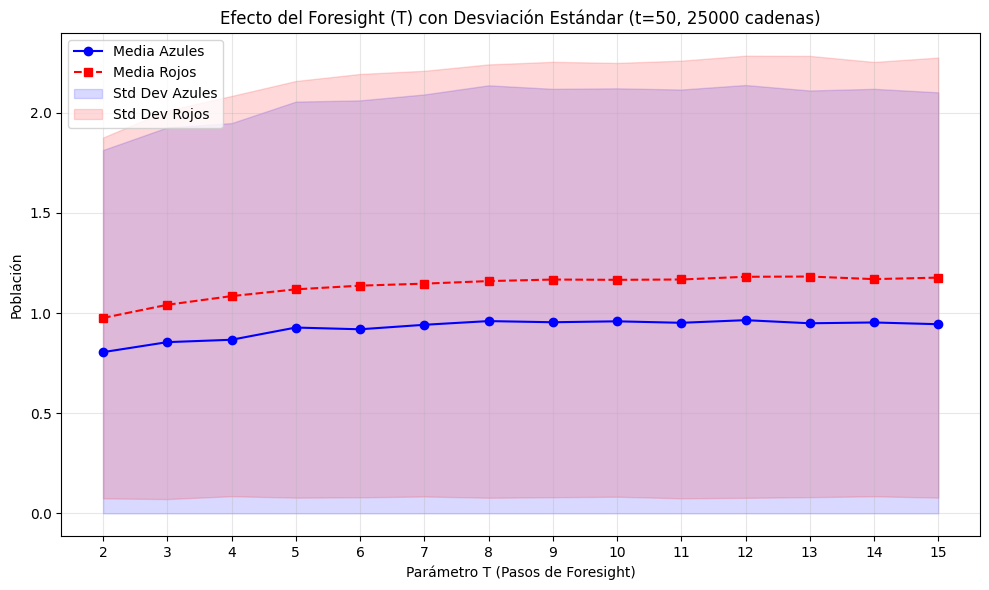

In [ ]:
# La rutina de visualización fue generada por Gemini 2.5 Pro, dadas las dos
# funciones definidas anteriormente (que se replican aquí para que la celda sea
# autocontenida) y los parámetros de la simulación para obtener la matriz de
# medias descrita en la celda de texto anterior.

import numpy as np
import time
import matplotlib.pyplot as plt

# --- FUNCIONES DEFINIDAS ANTERIORMENTE ---

def multiGW(estado_actual, prob_hijos, eventos_transicion):
    estado_actual = np.array(estado_actual)
    n_colores = len(estado_actual)
    nuevo_estado = np.zeros(n_colores, dtype=int)

    for i in range(n_colores):
        n_individuos = estado_actual[i]
        if n_individuos == 0: continue

        n_reproductores = np.random.binomial(n_individuos, prob_hijos[i])
        if n_reproductores == 0: continue

        info_eventos = eventos_transicion[i]
        probs = [e[0] for e in info_eventos]
        deltas = np.array([e[1] for e in info_eventos])

        conteo_eventos = np.random.multinomial(n_reproductores, probs)
        nuevo_estado += np.dot(conteo_eventos, deltas)

    return nuevo_estado

def multiGW_miope(estado_actual, prob_hijos, eventos_transicion, T, Tf):
    historia = [np.array(estado_actual)]
    intentos = 0
    max_intentos = 50000

    while len(historia) <= Tf:
        if intentos > max_intentos:
            return np.zeros_like(estado_actual)

        estado_previo = historia[-1]
        nuevo_estado = multiGW(estado_previo, prob_hijos, eventos_transicion)

        if np.sum(nuevo_estado) > 0:
            historia.append(nuevo_estado)
        else:
            intentos += 1
            corte = max(1, len(historia) - T)
            historia = historia[:corte]

    return historia[-1]

# --- PARÁMETROS DEL EXPERIMENTO ---

estado_inicial = [10, 10]
prob_hijos = [4/5, 4/5]

eventos_transicion = [
    [ [1/4, [2,0]], [3/4, [0,1]] ],
    [ [1/2, [1,0]], [1/2, [0,1]] ]
]

# Configuración
n_cadenas = 25000
T_final = 50
rango_T = range(2, 16)

# Listas para guardar las medias y desviaciones estándar
medias_azules = []
medias_rojos = []
std_azules = []
std_rojos = []

print(f"Iniciando estudio de sensibilidad para T en {list(rango_T)}")
print(f"Cadenas por T: {n_cadenas} | Horizonte Tf: {T_final}")
print("-" * 50)

# De aquí en adelante el código fue generado por Gemini 2.5 Pro

# --- BUCLE PRINCIPAL (Iterando sobre T) ---

for T_foresight in rango_T:
    start_time = time.time()
    resultados_T = []

    for i in range(n_cadenas):
        res = multiGW_miope(estado_inicial, prob_hijos, eventos_transicion, T_foresight, T_final)
        resultados_T.append(res)

    matriz_resultados = np.array(resultados_T)
    poblacion_total = np.sum(matriz_resultados, axis=1)

    validos = poblacion_total > 0
    n_validos = np.sum(validos)

    if n_validos > 0:
        matriz_validos = matriz_resultados[validos]

        # Calcular medias
        medias_por_color = np.mean(matriz_validos, axis=0)
        media_azul = medias_por_color[0]
        media_rojo = medias_por_color[1]

        # Calcular desviaciones estándar (std)
        stds_por_color = np.std(matriz_validos, axis=0)
        std_azul = stds_por_color[0]
        std_rojo = stds_por_color[1]
    else:
        media_azul, media_rojo = 0, 0
        std_azul, std_rojo = 0, 0

    medias_azules.append(media_azul)
    medias_rojos.append(media_rojo)
    std_azules.append(std_azul) # Guardar std
    std_rojos.append(std_rojo)  # Guardar std

    elapsed = time.time() - start_time
    print(f"T={T_foresight}: Medias -> Azul={media_azul:.2f}, Rojo={media_rojo:.2f} | Std -> A={std_azul:.2f}, R={std_rojo:.2f} ({elapsed:.2f}s)")

# --- GRAFICAR RESULTADOS ---

plt.figure(figsize=(10, 6))

# Convertir a numpy array para facilitar operaciones matemáticas en la gráfica
x = np.array(rango_T)
mu_azul = np.array(medias_azules)
mu_rojo = np.array(medias_rojos)
sigma_azul = np.array(std_azules)
sigma_rojo = np.array(std_rojos)

# Graficar líneas de media
plt.plot(x, mu_azul, marker='o', linestyle='-', label='Media Azules', color='blue')
plt.plot(x, mu_rojo, marker='s', linestyle='--', label='Media Rojos', color='red')

# Graficar desviación estándar (Sombra)
# Usamos np.maximum(0, ...) para que la sombra inferior no baje de 0 (población negativa imposible)
plt.fill_between(x, np.maximum(0, mu_azul - sigma_azul), mu_azul + sigma_azul, color='blue', alpha=0.15, label='Std Dev Azules')
plt.fill_between(x, np.maximum(0, mu_rojo - sigma_rojo), mu_rojo + sigma_rojo, color='red', alpha=0.15, label='Std Dev Rojos')

plt.title(f'Efecto del Foresight (T) con Desviación Estándar (t={T_final}, {n_cadenas} cadenas)')
plt.xlabel('Parámetro T (Pasos de Foresight)')
plt.ylabel('Población')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rango_T)

plt.tight_layout()
plt.show()

#### Simulación con más foresight


Iniciando estudio de sensibilidad para T en [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
Cadenas por T: 5000 | Horizonte Tf: 50
--------------------------------------------------
T=5: Medias -> Azul=0.87, Rojo=1.09 | Std -> A=1.06, R=1.01 (9.90s)
T=10: Medias -> Azul=0.94, Rojo=1.18 | Std -> A=1.17, R=1.07 (19.04s)
T=15: Medias -> Azul=0.96, Rojo=1.19 | Std -> A=1.16, R=1.11 (32.33s)
T=20: Medias -> Azul=0.94, Rojo=1.19 | Std -> A=1.15, R=1.10 (56.21s)
T=25: Medias -> Azul=0.98, Rojo=1.17 | Std -> A=1.18, R=1.10 (79.03s)
T=30: Medias -> Azul=0.95, Rojo=1.15 | Std -> A=1.17, R=1.09 (90.69s)
T=35: Medias -> Azul=0.97, Rojo=1.13 | Std -> A=1.16, R=1.07 (94.26s)
T=40: Medias -> Azul=0.92, Rojo=1.15 | Std -> A=1.12, R=1.04 (99.48s)
T=45: Medias -> Azul=0.94, Rojo=1.17 | Std -> A=1.20, R=1.09 (99.87s)
T=50: Medias -> Azul=0.93, Rojo=1.15 | Std -> A=1.14, R=1.09 (100.98s)


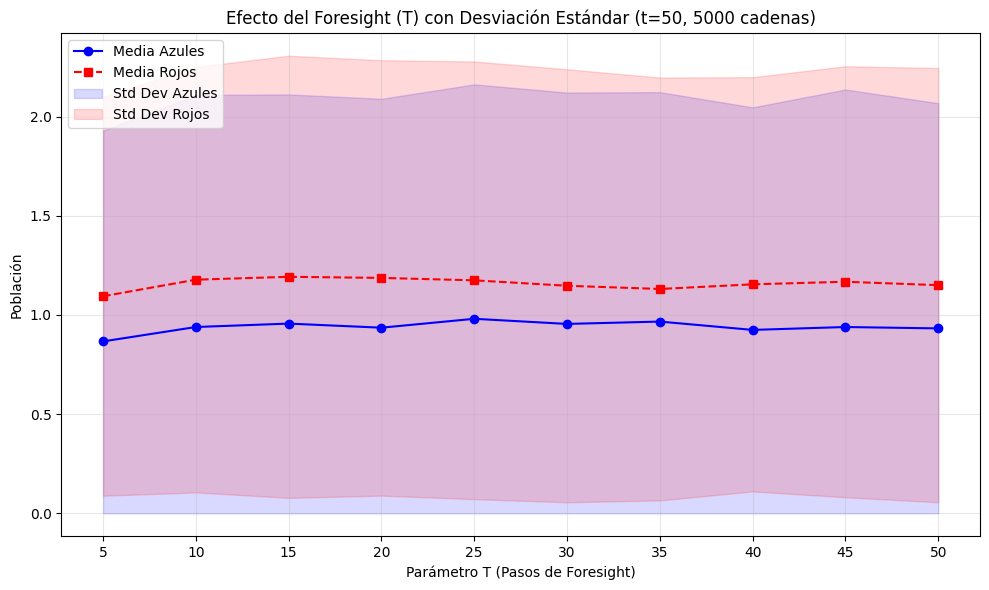

In [ ]:
# Esta celda es la misma que la anterior, pero modificamos parámetros para
# ver valores mayores de T. Por lo tanto, la rutina de visualización está
# también generada por Gemini 2.5 Pro a partir de las funciones de simulación
# definidas anteriormente.

import numpy as np
import time
import matplotlib.pyplot as plt

# --- FUNCIONES NECESARIAS ---

def multiGW(estado_actual, prob_hijos, eventos_transicion):
    estado_actual = np.array(estado_actual)
    n_colores = len(estado_actual)
    nuevo_estado = np.zeros(n_colores, dtype=int)

    for i in range(n_colores):
        n_individuos = estado_actual[i]
        if n_individuos == 0: continue

        n_reproductores = np.random.binomial(n_individuos, prob_hijos[i])
        if n_reproductores == 0: continue

        info_eventos = eventos_transicion[i]
        probs = [e[0] for e in info_eventos]
        deltas = np.array([e[1] for e in info_eventos])

        conteo_eventos = np.random.multinomial(n_reproductores, probs)
        nuevo_estado += np.dot(conteo_eventos, deltas)

    return nuevo_estado

def multiGW_miope(estado_actual, prob_hijos, eventos_transicion, T, Tf):
    historia = [np.array(estado_actual)]
    intentos = 0
    max_intentos = 50000

    while len(historia) <= Tf:
        if intentos > max_intentos:
            return np.zeros_like(estado_actual)

        estado_previo = historia[-1]
        nuevo_estado = multiGW(estado_previo, prob_hijos, eventos_transicion)

        if np.sum(nuevo_estado) > 0:
            historia.append(nuevo_estado)
        else:
            intentos += 1
            corte = max(1, len(historia) - T)
            historia = historia[:corte]

    return historia[-1]

# --- PARÁMETROS DEL EXPERIMENTO ---

estado_inicial = [10, 10]
prob_hijos = [4/5, 4/5]

eventos_transicion = [
    # Azul: Esperanza ~ 1.0 hijos
    [ [1/4, [2,0]], [3/4, [0,1]] ],

    # Rojo: Esperanza ~ 0.8 hijos
    [ [1/2, [1,0]], [1/2, [0,1]] ]
]

# Configuración
n_cadenas = 5000
T_final = 50
rango_T = range(5,55,5)

# Listas para guardar las medias y desviaciones estándar
medias_azules = []
medias_rojos = []
std_azules = []
std_rojos = []

print(f"Iniciando estudio de sensibilidad para T en {list(rango_T)}")
print(f"Cadenas por T: {n_cadenas} | Horizonte Tf: {T_final}")
print("-" * 50)

# De aquí en adelante el código fue generado por Gemini 2.5 Pro

# --- BUCLE PRINCIPAL (Iterando sobre T) ---

for T_foresight in rango_T:
    start_time = time.time()
    resultados_T = []

    for i in range(n_cadenas):
        res = multiGW_miope(estado_inicial, prob_hijos, eventos_transicion, T_foresight, T_final)
        resultados_T.append(res)

    matriz_resultados = np.array(resultados_T)
    poblacion_total = np.sum(matriz_resultados, axis=1)

    validos = poblacion_total > 0
    n_validos = np.sum(validos)

    if n_validos > 0:
        matriz_validos = matriz_resultados[validos]

        # Calcular medias
        medias_por_color = np.mean(matriz_validos, axis=0)
        media_azul = medias_por_color[0]
        media_rojo = medias_por_color[1]

        # Calcular desviaciones estándar (std)
        stds_por_color = np.std(matriz_validos, axis=0)
        std_azul = stds_por_color[0]
        std_rojo = stds_por_color[1]
    else:
        media_azul, media_rojo = 0, 0
        std_azul, std_rojo = 0, 0

    medias_azules.append(media_azul)
    medias_rojos.append(media_rojo)
    std_azules.append(std_azul) # Guardar std
    std_rojos.append(std_rojo)  # Guardar std

    elapsed = time.time() - start_time
    print(f"T={T_foresight}: Medias -> Azul={media_azul:.2f}, Rojo={media_rojo:.2f} | Std -> A={std_azul:.2f}, R={std_rojo:.2f} ({elapsed:.2f}s)")

# --- GRAFICAR RESULTADOS ---

plt.figure(figsize=(10, 6))

# Convertir a numpy array para facilitar operaciones matemáticas en la gráfica
x = np.array(rango_T)
mu_azul = np.array(medias_azules)
mu_rojo = np.array(medias_rojos)
sigma_azul = np.array(std_azules)
sigma_rojo = np.array(std_rojos)

# Graficar líneas de media
plt.plot(x, mu_azul, marker='o', linestyle='-', label='Media Azules', color='blue')
plt.plot(x, mu_rojo, marker='s', linestyle='--', label='Media Rojos', color='red')

# Graficar desviación estándar (Sombra)
# Usamos np.maximum(0, ...) para que la sombra inferior no baje de 0 (población negativa imposible)
plt.fill_between(x, np.maximum(0, mu_azul - sigma_azul), mu_azul + sigma_azul, color='blue', alpha=0.15, label='Std Dev Azules')
plt.fill_between(x, np.maximum(0, mu_rojo - sigma_rojo), mu_rojo + sigma_rojo, color='red', alpha=0.15, label='Std Dev Rojos')

plt.title(f'Efecto del Foresight (T) con Desviación Estándar (t={T_final}, {n_cadenas} cadenas)')
plt.xlabel('Parámetro T (Pasos de Foresight)')
plt.ylabel('Población')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rango_T)

plt.tight_layout()
plt.show()

### Un caso crítico

Vemos en lo anterior que para parámetros pequeños de *foresight* el valor esperado de la población tiende a crecer, pese a tener mucha varianza. El efecto deja de ser pronunciado para $T\geq 10$ aproximadamente. Conjeturamos que el efecto debería notarse más si, por ejemplo, el valor esperado para la progenia de nodos rojos para un padre rojo es muy alta: el condicionamiento miope debería tender a "escoger" más nodos rojos para asegurar la supervivencia de la población.

Motivados en parte por esto, consideramos la matriz de medias
$$\begin{pmatrix} 1/3 & 2/9 \\ 1/3 & 8/9 \end{pmatrix}$$
que tiene valores propios $\lambda_1=1$ y $\lambda_2=2/9$. Por lo tanto, su radio espectral es $1$ y un proceso multi-GW con esta matriz describe un caso crítico, que se extingue en tiempo finito c.s. pero sin decaimiento exponencial.

Simulémoslo primero sin condicionamiento para asegurarnos de que la población sigue extinguiéndose "rápidamente", y luego estudiemos qué ocurre con condicionamiento miope en función del foresight $T$:

In [ ]:
# Simulación de un caso crítico:

estado_inicial = [1,1]
prob_hijos = [2/3, 1/3]
eventos_transicion = [
    [[1/2, [1,0]], [1/2, [0,1]]],  # Eventos para Azul (índice 0)
    [[2/3, [1,0]], [1/3, [0,8]]]   # Eventos para Rojo (índice 1)
]

n_cadenas = 10000
t_max = 10000

# --- Ejecución ---

tiempos_de_muerte = []
cadenas_extintas = 0

for i in range(n_cadenas):
    estado = np.array(estado_inicial)
    extinta = False

    # Simulamos paso a paso hasta t_max
    for t in range(1, t_max + 1):
        estado = multiGW(estado, prob_hijos, eventos_transicion)

        # Verificamos si la población total es 0
        if np.sum(estado) == 0:
            tiempos_de_muerte.append(t)
            cadenas_extintas += 1
            extinta = True
            break

# --- Resultados ---

prob_muerte_estimada = cadenas_extintas / n_cadenas

if len(tiempos_de_muerte) > 0:
    tiempo_promedio = np.mean(tiempos_de_muerte)
    mediana_tiempo = np.median(tiempos_de_muerte)
else:
    tiempo_promedio = 0
    mediana_tiempo = 0

print(f"Simulación completada con {n_cadenas} cadenas.")
print(f"Probabilidad estimada de extinción: {prob_muerte_estimada:.4f}")
print(f"Tiempo promedio de extinción: {tiempo_promedio:.2f} generaciones")
print(f"Mediana del tiempo de extinción: {mediana_tiempo}")

Simulación completada con 10000 cadenas.
Probabilidad estimada de extinción: 1.0000
Tiempo promedio de extinción: 7.96 generaciones
Mediana del tiempo de extinción: 2.0


Iniciando estudio de sensibilidad para T en [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
Cadenas por T: 10000 | Horizonte Tf: 50
--------------------------------------------------
T=5: Medias -> Azul=22.13, Rojo=66.32 | Std -> A=27.20, R=84.59 (25.88s)
T=10: Medias -> Azul=29.31, Rojo=87.54 | Std -> A=32.27, R=98.97 (30.99s)
T=15: Medias -> Azul=32.41, Rojo=97.33 | Std -> A=34.63, R=107.13 (39.94s)
T=20: Medias -> Azul=34.28, Rojo=103.22 | Std -> A=34.93, R=108.62 (49.24s)
T=25: Medias -> Azul=36.13, Rojo=108.67 | Std -> A=37.38, R=115.63 (60.51s)
T=30: Medias -> Azul=36.11, Rojo=108.62 | Std -> A=37.16, R=115.64 (62.48s)
T=35: Medias -> Azul=36.15, Rojo=108.32 | Std -> A=37.40, R=115.56 (65.75s)
T=40: Medias -> Azul=36.42, Rojo=109.42 | Std -> A=37.79, R=117.32 (71.98s)
T=45: Medias -> Azul=35.91, Rojo=107.14 | Std -> A=37.32, R=115.23 (68.20s)
T=50: Medias -> Azul=36.20, Rojo=108.78 | Std -> A=37.25, R=115.24 (74.17s)


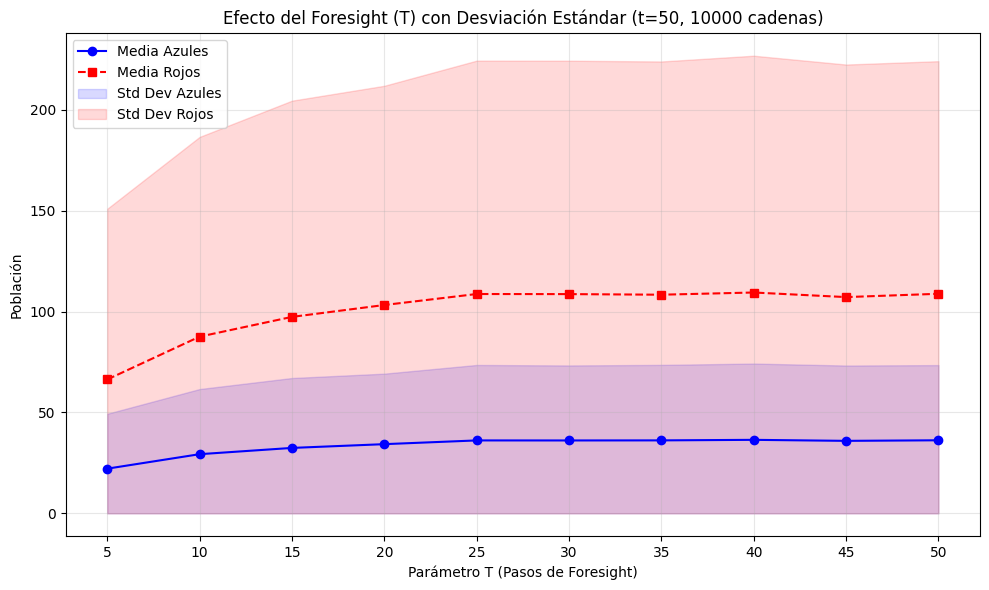

In [ ]:
# Nuevamente, esta celda es copy-paste de las anteriores modificando solo
# los parámetros de la simulación. El loop de simulación y visualización
# fueron hechos por Gemini 2.5 Pro

import numpy as np
import time
import matplotlib.pyplot as plt

# --- FUNCIONES NECESARIAS ---

def multiGW(estado_actual, prob_hijos, eventos_transicion):
    estado_actual = np.array(estado_actual)
    n_colores = len(estado_actual)
    nuevo_estado = np.zeros(n_colores, dtype=int)

    for i in range(n_colores):
        n_individuos = estado_actual[i]
        if n_individuos == 0: continue

        n_reproductores = np.random.binomial(n_individuos, prob_hijos[i])
        if n_reproductores == 0: continue

        info_eventos = eventos_transicion[i]
        probs = [e[0] for e in info_eventos]
        deltas = np.array([e[1] for e in info_eventos])

        conteo_eventos = np.random.multinomial(n_reproductores, probs)
        nuevo_estado += np.dot(conteo_eventos, deltas)

    return nuevo_estado

def multiGW_miope(estado_actual, prob_hijos, eventos_transicion, T, Tf):
    historia = [np.array(estado_actual)]
    intentos = 0
    max_intentos = 50000

    while len(historia) <= Tf:
        if intentos > max_intentos:
            return np.zeros_like(estado_actual)

        estado_previo = historia[-1]
        nuevo_estado = multiGW(estado_previo, prob_hijos, eventos_transicion)

        if np.sum(nuevo_estado) > 0:
            historia.append(nuevo_estado)
        else:
            intentos += 1
            corte = max(1, len(historia) - T)
            historia = historia[:corte]

    return historia[-1]

# --- PARÁMETROS DEL EXPERIMENTO ---

estado_inicial = [1,1]
prob_hijos = [2/3, 1/3]
eventos_transicion = [
    [[1/2, [1,0]], [1/2, [0,1]]],  # Eventos para Azul (índice 0)
    [[2/3, [1,0]], [1/3, [0,8]]]   # Eventos para Rojo (índice 1)
]

# Configuración
n_cadenas = 10000
T_final = 50
rango_T = range(5,55,5)

# Listas para guardar las medias y desviaciones estándar
medias_azules = []
medias_rojos = []
std_azules = []    # <--- Nueva lista para desviación estándar Azul
std_rojos = []     # <--- Nueva lista para desviación estándar Roja

print(f"Iniciando estudio de sensibilidad para T en {list(rango_T)}")
print(f"Cadenas por T: {n_cadenas} | Horizonte Tf: {T_final}")
print("-" * 50)

# De aquí en adelante el código fue generado por Gemini 2.5 Pro

# --- BUCLE PRINCIPAL (Iterando sobre T) ---

for T_foresight in rango_T:
    start_time = time.time()
    resultados_T = []

    for i in range(n_cadenas):
        res = multiGW_miope(estado_inicial, prob_hijos, eventos_transicion, T_foresight, T_final)
        resultados_T.append(res)

    matriz_resultados = np.array(resultados_T)
    poblacion_total = np.sum(matriz_resultados, axis=1)

    validos = poblacion_total > 0
    n_validos = np.sum(validos)

    if n_validos > 0:
        matriz_validos = matriz_resultados[validos]

        # Calcular medias
        medias_por_color = np.mean(matriz_validos, axis=0)
        media_azul = medias_por_color[0]
        media_rojo = medias_por_color[1]

        # Calcular desviaciones estándar (std)
        stds_por_color = np.std(matriz_validos, axis=0)
        std_azul = stds_por_color[0]
        std_rojo = stds_por_color[1]
    else:
        media_azul, media_rojo = 0, 0
        std_azul, std_rojo = 0, 0

    medias_azules.append(media_azul)
    medias_rojos.append(media_rojo)
    std_azules.append(std_azul) # Guardar std
    std_rojos.append(std_rojo)  # Guardar std

    elapsed = time.time() - start_time
    print(f"T={T_foresight}: Medias -> Azul={media_azul:.2f}, Rojo={media_rojo:.2f} | Std -> A={std_azul:.2f}, R={std_rojo:.2f} ({elapsed:.2f}s)")

# --- GRAFICAR RESULTADOS ---

plt.figure(figsize=(10, 6))

# Convertir a numpy array para facilitar operaciones matemáticas en la gráfica
x = np.array(rango_T)
mu_azul = np.array(medias_azules)
mu_rojo = np.array(medias_rojos)
sigma_azul = np.array(std_azules)
sigma_rojo = np.array(std_rojos)

# Graficar líneas de media
plt.plot(x, mu_azul, marker='o', linestyle='-', label='Media Azules', color='blue')
plt.plot(x, mu_rojo, marker='s', linestyle='--', label='Media Rojos', color='red')

# Graficar desviación estándar (Sombra)
# Usamos np.maximum(0, ...) para que la sombra inferior no baje de 0 (población negativa imposible)
plt.fill_between(x, np.maximum(0, mu_azul - sigma_azul), mu_azul + sigma_azul, color='blue', alpha=0.15, label='Std Dev Azules')
plt.fill_between(x, np.maximum(0, mu_rojo - sigma_rojo), mu_rojo + sigma_rojo, color='red', alpha=0.15, label='Std Dev Rojos')

plt.title(f'Efecto del Foresight (T) con Desviación Estándar (t={T_final}, {n_cadenas} cadenas)')
plt.xlabel('Parámetro T (Pasos de Foresight)')
plt.ylabel('Población')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rango_T)

plt.tight_layout()
plt.show()

### Distancia de autovectores a la base canónica

En la simulación anterior vemos que la proporción entre nodos rojos y nodos azules crece con $T$. Conjeturamos que esto debe ocurrir si el vector propio líder (*leading eigenvector*) de la matriz de medias es cercano al vector canónico correspondiente a la coordenada de los nodos rojos -- en este caso, a $(0,1)$. Esto es de esperar pues el vector propio líder describe la dirección principal de crecimiento para la dinámica discreta definida por $M$.

Para generar evidencia numérica para esta conjetura, generamos matrices de medias aleatorias dentro de cierta familia y estudiamos su distancia a un vector canónico como variable independiente, y por otra parte la razón entre ambos colores, y luego estudiamos la correlación entre ambas variables:

In [ ]:
def generar_matriz_random():
    """
    Genera una matriz de medias M dentro de una familia determinada.
    Retorna la matriz M y las probabilidades para la simulación.
    """
    # 1. Probabilidades de Reproducción (entre 0.5 y 0.95 para que no mueran tan rápido)
    p_repro_R = np.random.uniform(0.5, 0.95)
    p_repro_A = np.random.uniform(0.5, 0.95)

    # 2. Distribución condicional
    # Por efectos de simplificación consideramos que o bien sobrevive o hace mitosis con mutación
    # ROJO:
    prob_solo_R = np.random.random() # Prob de tener hijo (1, 0)
    prob_mix_R  = 1 - prob_solo_R    # Prob de tener hijo (1, 1)

    # AZUL:
    prob_solo_A = np.random.random() # Prob de tener hijo (0, 1)
    prob_mix_A  = 1 - prob_solo_A    # Prob de tener hijo (1, 1)

    # 3. Construir Matriz M (Esperanzas)
    # Rojo
    mu_RR = p_repro_R * (1*prob_solo_R + 1*prob_mix_R)
    mu_RA = p_repro_R * (1*prob_mix_R)
    # Azul
    mu_AR = p_repro_A * (1*prob_mix_A)
    mu_AA = p_repro_A * (1*prob_solo_A + 1*prob_mix_A)

    M = np.array([[mu_RR, mu_RA],
                  [mu_AR, mu_AA]])

    # Guardamos los params para simular
    params = {
        'pR': p_repro_R, 'distR': [prob_solo_R, prob_mix_R],
        'pA': p_repro_A, 'distA': [prob_solo_A, prob_mix_A]
    }
    return M, params
def obtener_autovector_izquierdo(M):
    """Calcula el autovector izquierdo asociado al mayor valor propio (normalizado a suma 1)."""
    # El autovector izquierdo de M es el derecho de M transpuesta
    vals, vecs = np.linalg.eig(M.T)

    # Buscar índice del mayor valor propio real
    idx = np.argmax(np.abs(vals))

    # Tomar el vector y tomar valor absoluto
    v = np.abs(vecs[:, idx])

    # Normalizar para que sume 1 (proporciones)
    return v / np.sum(v)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def correlacion_ev_ratio_GW(estado_inicial, T, K, n_cadenas):
    """
    Grafica la relación entre la distancia teórica y la proporción simulada.
    """
    # Usaremos listas para ir guardando solo los casos donde hubo supervivencia
    distancias_guardadas = []
    proporciones_guardadas = []

    for k in range(K):
        M, params = generar_matriz_random()
        autovector = obtener_autovector_izquierdo(M)

        # Calculamos la distancia al canónico rojo [1, 0]
        # (Cuanto mayor la distancia, más "Azul" es la teoría)
        dist = np.linalg.norm(autovector - np.array([1, 0]))

        pR, distR = params['pR'], params['distR']
        pA, distA = params['pA'], params['distA']
        prob_hijos = [pR, pA]
        #Definimos probabilidad de las transiciones
        eventos_transicion = [
            [[distR[0], [1,0]], [distR[1], [1,1]]], # Rojo: Solo o Mix
            [[distA[0], [0,1]], [distA[1], [1,1]]]  # Azul: Solo o Mix
        ]

        cadenas_supervivientes = []

        # 2. Simulación de Monte Carlo
        for i in range(n_cadenas):
            estado = np.array(estado_inicial)

            for t in range(T):
                estado = multiGW(estado, prob_hijos, eventos_transicion)

                if np.sum(estado) == 0:
                    break

            if np.sum(estado) > 0:
                cadenas_supervivientes.append(estado)

        # 3. Procesamiento de Resultados
        n_vivas = len(cadenas_supervivientes)

        # Solo procesamos si al menos una cadena sobrevivió
        if n_vivas > 0:
            matriz_final = np.array(cadenas_supervivientes) # shape: (n_vivas, 2)

            # Población total por cadena
            poblacion_total = np.sum(matriz_final, axis=1)

            # Cálculo de proporciones (Azules sobre Total)
            # Si estado es [R, A], Azul es índice 1.
            # Si queremos graficar correlación positiva con la distancia (que crece hacia el azul),
            props_azules = matriz_final[:, 1] / poblacion_total

            promedio_azul_simulado = np.mean(props_azules)

            # Guardamos los datos para el plot
            distancias_guardadas.append(dist)
            proporciones_guardadas.append(promedio_azul_simulado)

            print(f"Matriz {k+1}/{K}: Supervivencia {n_vivas/n_cadenas:.2f} | Dist: {dist:.3f} | %Azul: {promedio_azul_simulado:.3f}")
        else:
            print(f"Matriz {k+1}/{K}: Extinción total. Saltando.")

    # 4. Graficar (Principalmente modificado con GEMINI)
    plt.figure(figsize=(16, 9))

    # Convertimos a numpy array para facilitar el manejo en plot
    x = np.array(distancias_guardadas)
    y = np.array(proporciones_guardadas)

    plt.scatter(x, y, alpha=0.6, c='purple', edgecolors='k', label='Simulaciones')

    # Línea de identidad ajustada (aprox)
    # Nota: La distancia máxima teorica (de [1,0] a [0,1]) es sqrt(2) approx 1.41
    plt.plot([0, 1.45], [0, 1.0], 'r--', label='Tendencia Esperada')

    plt.title(f'Distancia del vector propio lider al Rojo vs. Proporción de Azules (T={T})')
    plt.xlabel('Distancia Teórica (Vector propio vs [1,0])')
    plt.ylabel('Proporción de Azules Simulada')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

Matriz 1/30: Supervivencia 0.99 | Dist: 0.685 | %Azul: 0.484
Matriz 2/30: Supervivencia 0.99 | Dist: 0.619 | %Azul: 0.440
Matriz 3/30: Supervivencia 0.99 | Dist: 0.501 | %Azul: 0.352
Matriz 4/30: Supervivencia 1.00 | Dist: 0.938 | %Azul: 0.663
Matriz 5/30: Supervivencia 0.00 | Dist: 0.235 | %Azul: 0.000
Matriz 6/30: Supervivencia 0.61 | Dist: 0.963 | %Azul: 0.751
Matriz 7/30: Supervivencia 1.00 | Dist: 0.715 | %Azul: 0.506
Matriz 8/30: Supervivencia 0.17 | Dist: 0.681 | %Azul: 0.457
Matriz 9/30: Supervivencia 0.09 | Dist: 0.633 | %Azul: 0.459
Matriz 10/30: Supervivencia 0.55 | Dist: 0.768 | %Azul: 0.549
Matriz 11/30: Supervivencia 0.00 | Dist: 0.460 | %Azul: 0.000
Matriz 12/30: Supervivencia 1.00 | Dist: 0.707 | %Azul: 0.500
Matriz 13/30: Supervivencia 0.29 | Dist: 0.953 | %Azul: 0.708
Matriz 14/30: Supervivencia 1.00 | Dist: 0.889 | %Azul: 0.628
Matriz 15/30: Supervivencia 0.97 | Dist: 0.856 | %Azul: 0.611
Matriz 16/30: Supervivencia 0.81 | Dist: 0.591 | %Azul: 0.404
Matriz 17/30: Sup

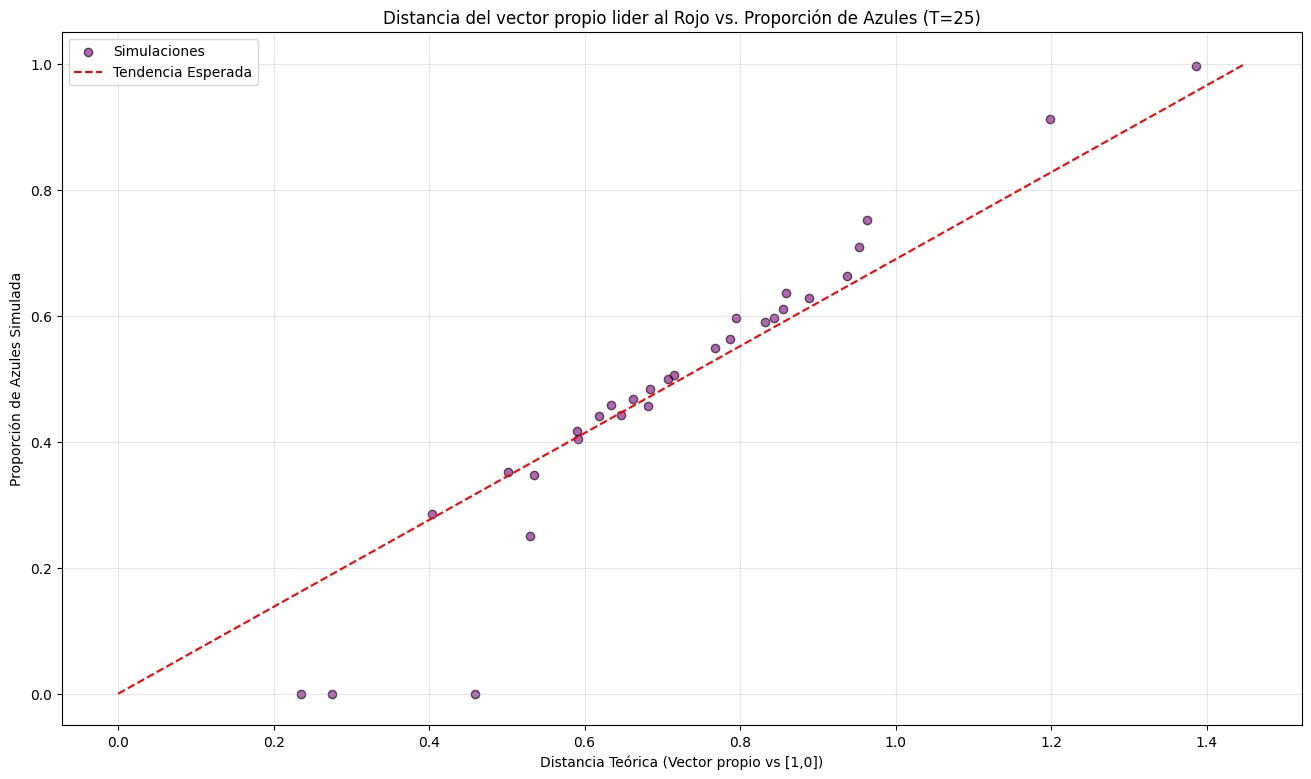

In [ ]:
correlacion_ev_ratio_GW([10,10],25,30,2500)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def correlacion_ev_ratio_GWMIOPE(estado_inicial, T,T_foresight,K, n_cadenas):
    """
    Grafica la relación entre la distancia teórica y la proporción simulada.
    """
    # Usaremos listas para ir guardando solo los casos donde hubo supervivencia
    distancias_guardadas = []
    proporciones_guardadas = []

    for k in range(K):
        M, params = generar_matriz_random()
        autovector = obtener_autovector_izquierdo(M)

        # Calculamos la distancia al canónico rojo [1, 0]
        # (Cuanto mayor la distancia, más "Azul" es la teoría)
        dist = np.linalg.norm(autovector - np.array([1, 0]))

        pR, distR = params['pR'], params['distR']
        pA, distA = params['pA'], params['distA']
        prob_hijos = [pR, pA]

        # Probabilidades de transición
        eventos_transicion = [
            [[distR[0], [1,0]], [distR[1], [1,1]]], # Rojo: Solo o Mix
            [[distA[0], [0,1]], [distA[1], [1,1]]]  # Azul: Solo o Mix
        ]

        cadenas_supervivientes = []

        #  Simulación de Monte Carlo
        for i in range(n_cadenas):
            estado = np.array(estado_inicial)

            for t in range(T):
                estado = multiGW_miope(estado, prob_hijos, eventos_transicion,T_foresight,T)

                if np.sum(estado) == 0:
                    break

            if np.sum(estado) > 0:
                cadenas_supervivientes.append(estado)

        # 3. Procesamiento de Resultados
        n_vivas = len(cadenas_supervivientes)

        # Solo procesamos si al menos una cadena sobrevivió
        if n_vivas > 0:
            matriz_final = np.array(cadenas_supervivientes) # shape: (n_vivas, 2)

            # Población total por cadena
            poblacion_total = np.sum(matriz_final, axis=1)

            # Cálculo de proporciones (Azules sobre Total)
            # Si estado es [R, A], Azul es índice 1.
            # Si queremos graficar correlación positiva con la distancia (que crece hacia el azul),
            # debemos graficar la proporción de AZULES.
            props_azules = matriz_final[:, 1] / poblacion_total

            promedio_azul_simulado = np.mean(props_azules)

            # Guardamos los datos para el plot
            distancias_guardadas.append(dist)
            proporciones_guardadas.append(promedio_azul_simulado)

            print(f"Matriz {k+1}/{K}: Supervivencia {n_vivas/n_cadenas:.2f} | Dist: {dist:.3f} | %Azul: {promedio_azul_simulado:.3f}")
        else:
            print(f"Matriz {k+1}/{K}: Extinción total. Saltando.")

    # 4. Graficar (Principalmente modificado por GEMINI)
    plt.figure(figsize=(16, 9))

    # Convertimos a numpy array para facilitar el manejo en plot
    x = np.array(distancias_guardadas)
    y = np.array(proporciones_guardadas)

    plt.scatter(x, y, alpha=0.6, c='purple', edgecolors='k', label='Simulaciones')

    # Línea de identidad ajustada (aprox)
    # Nota: La distancia máxima teorica (de [1,0] a [0,1]) es sqrt(2) approx 1.41
    plt.plot([0, 1.45], [0, 1.0], 'r--', label='Tendencia Esperada')

    plt.title(f'Distancia del vector propio lider al Rojo vs. Proporción de Azules (Míope T_foresight = {T_foresight}) (T={T})')
    plt.xlabel('Distancia Teórica (Autovector vs [1,0])')
    plt.ylabel('Proporción de Azules Simulada')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


In [ ]:
# Toma algo de tiempo ejecutar esto:
correlacion_ev_ratio_GWMIOPE([10,10],15,2,20,200)

# Referencias

- T. Harris (1963), *The Theory of Branching Processes*. Springer.